In [1]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import os

In [2]:
np.random.seed(111)  # reproducibility
torch.cuda.is_available() 

True

In [3]:
# Enforcing GPU usage if available 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Loading file paths

train_path = 'D:/DataScience/CMAPSS/Data/train_FD00X.txt'
test_path = 'D:/DataScience/CMAPSS/Data/test_FD00X.txt'
RUL_path = 'D:/DataScience/CMAPSS/Data/RUL_FD00X.txt'

#train_path = f'E:/CMAPSS/data/train_FD00X.txt'
#test_path = f'E:/CMAPSS/data/test_FD00X.txt'
#RUL_path = f'E:/CMAPSS/data/RUL_FD00X.txt'


labels = ['unit', 'cycles', 'opMode1', 'opMode2', 'opMode3'] + [f'sensor{i}' for i in range(1, 22)]  # column headers, see readme file

In [5]:
# Function to load data and drop the columns specified by cols_to_drop, and add an RUL column for each unit
def load_data(filepath, rul=False):
    data = []
    # Creating lists which hold dataframes for each test trajectory
    if not rul:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    names=labels, delimiter='\s+',
                                    ))
        return data
    else:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    delimiter='\s+', header=None,
                                    ))

        return data  # a list


def prepare_data(train_data: pd.DataFrame):
    # Adds an RUL column for training
    ### TRAINING DATAFRAMES ###

    rul = pd.DataFrame(train_data.groupby('unit')['cycles'].max()).reset_index()
    rul.columns = ['unit', 'max']

    train_data = train_data.merge(rul, on=['unit'], how='left')

    train_data['RUL'] = train_data['max'] - train_data['cycles']
    train_data.drop('max', axis=1, inplace=True)

    return train_data

In [6]:
# Initialising data
train_data, test_data, RUL_data = load_data(train_path), load_data(test_path), load_data(RUL_path, True)

In [7]:
# Adding RUL columns 
for i in range(len(train_data)):
    train_data[i] = prepare_data(train_data[i])

In [8]:
train_data[0]

,unit,cycles,opMode1,opMode2,opMode3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


We can observe, generally, the trend between the sensor readings and the RUL. Although the data is very noisy, the engines are all of the same make but only subject to different arbitrary conditions of wear and tear. We can go through a smaller subset of engine units, say 10 out of the 100. 


In [9]:
train_data[0].describe()

,unit,cycles,opMode1,opMode2,opMode3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000


Columns with a very low standard deviation can be ignored as it shows the values are roughly constant. Constant values do not have much bearing on machine learning methods.

In [8]:
def plot_sensor_reading(df, sensor_no):
    plt.figure(figsize=(12, 4))
    for i in df['unit'].unique():
        if (i % 10 == 0):  # 10 engines only (100 in total)
            plt.plot('RUL', sensor_no, data=df[df['unit'] == i].rolling(10).mean())
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(f'Sensor {sensor_no} reading')
    plt.xlabel('Remaining useful life (RUL)')
    plt.show()

In [8]:
# Trajectories FD001 and FD003 both have redundant readings which can be dropped as they are constant or rarely change. FD004 and FD002 both have a redundant sensor 16.
cols_to_drop = ['opMode3', 'sensor1', 'sensor5',
                'sensor6', 'sensor10', 'sensor16',
                'sensor18', 'sensor19', 'sensor17']

train_data[0].drop(columns=cols_to_drop, inplace=True)
train_data[2].drop(columns=cols_to_drop, inplace=True)
test_data[0].drop(columns=cols_to_drop, inplace=True)
test_data[2].drop(columns=cols_to_drop, inplace=True)

train_data[1].drop(columns=['sensor16'], inplace=True)
train_data[3].drop(columns=['sensor16'], inplace=True)


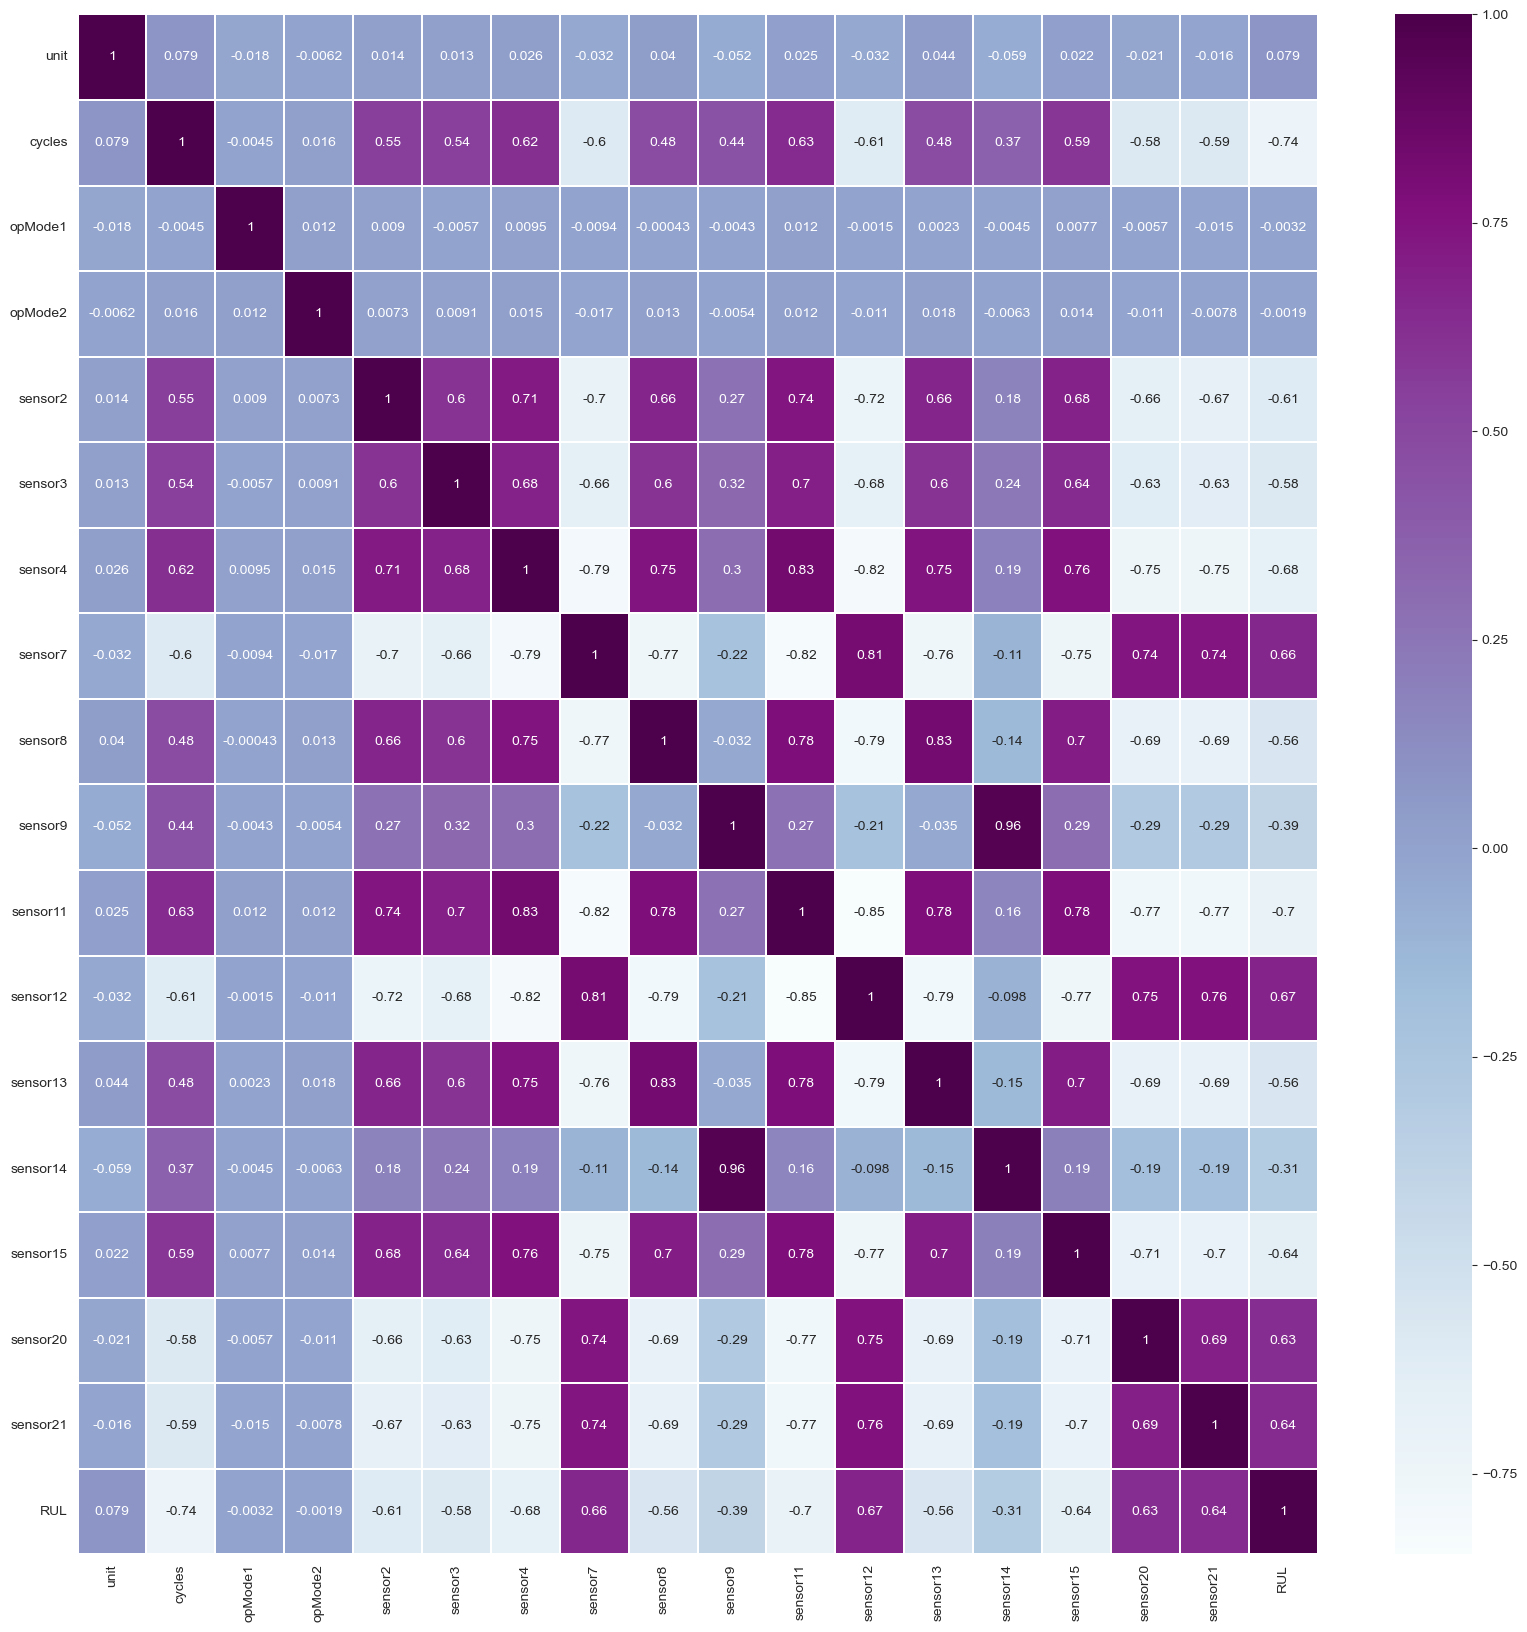

In [9]:
sns.heatmap(train_data[0].corr(), annot=True, cmap='BuPu', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()

In [10]:
# Removing properties with weak correlation and high inter-correlation
# sensor 14 and has aa very high correlation with sensor 9, we can remove sensor 14 to reduce multicollinearity
train_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
train_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)

In [11]:
# Min-max scaling the data, except [cycles, RUL]
scaler = MinMaxScaler(feature_range=(-1, 1))

train_data[0].iloc[:, 2:-1] = scaler.fit_transform(train_data[0].iloc[:, 2:-1])
test_data[0].iloc[:, 2:] = scaler.transform(test_data[0].iloc[:, 2:])

train_data[2].iloc[:, 2:-1] = scaler.fit_transform(train_data[2].iloc[:, 2:-1])
test_data[2].iloc[:, 2:] = scaler.transform(test_data[2].iloc[:, 2:])


The data is extremely noisy. Here we apply a Savitzky-Golay filter to retain the trend and shape while smoothing out any noise with a window length equal to the number of cycles any given unit has lasted for.

In [12]:
from scipy.signal import savgol_filter as svg

In [13]:
# applying Savitzky-Golay to all sensor readings
def filter_readings(df):
    temp = df.copy(deep=True)
    for i in df['unit'].unique():
        mask = df['unit'] == i
        masked = df[mask]
        if 'RUL' in masked.columns:
            for header, column in masked.drop(['unit', 'cycles', 'RUL'], axis=1).items():
                temp.loc[mask, header] = svg(column, window_length=len(column), polyorder=2)
        else:
            for header, column in masked.drop(['unit', 'cycles'], axis=1).items():
                temp.loc[mask, header] = svg(column, window_length=len(column), polyorder=2)
    return temp


In [15]:
a = filter_readings(train_data[0])

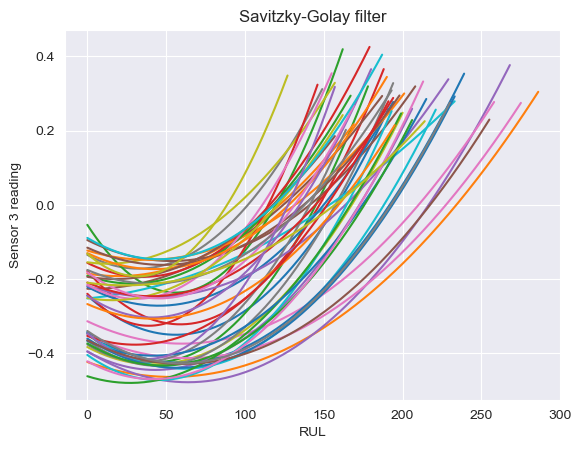

In [16]:
for i in range(1, 50):
    plt.plot(a[a['unit'] == i].reset_index()['sensor3'])
plt.title('Savitzky-Golay filter')
plt.xlabel('RUL')
plt.ylabel('Sensor 3 reading')
plt.show()


In [17]:
# Creating a training sequence
def create_training_sequence(df, seq_length, seq_cols):
    
    """function to prepare training data into (samples, time steps, features)
    df = training dataframe
    seq_length = look-back period
    seq_cols = feature columns"""

    data_array = df[seq_cols].values
    num_elements = data_array.shape[0]

    lstm_array = []

    for start, stop in zip(range(0, num_elements - seq_length + 1), range(seq_length, num_elements + 1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

def create_target_sequence(df, seq_length, label):
    data_array = df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length - 1:num_elements + 1]


def create_training_batch(df, seq_length, columns):
    """Since the test data is stopped some arbitrary time before failure,
       the number of engine cycles won't necessarily be longer than a given window length,
       so we generate testing sequences which meet the sequence_length 
       """
    x = np.concatenate(
        list(list(create_training_sequence(df[df['unit'] == i], seq_length, columns)) for i in df['unit'].unique()))
    y = np.concatenate(
        list(list(create_target_sequence(df[df['unit'] == i], seq_length, 'RUL')) for i in df['unit'].unique()))
    return x, y


In [18]:
FD_columns = [[column for column in df if column != 'RUL'] for df in train_data]

In [48]:
sequence_length = 10
trajectory = 0  # see readme file
batch_size = 128

In [49]:
FD001_train = filter_readings(train_data[trajectory])
FD001_test = filter_readings(test_data[trajectory])
FD001_truth = RUL_data[trajectory]

In [50]:
a, b = create_training_batch(FD001_train, sequence_length, FD_columns[trajectory])

In [51]:
feature_count = a.shape[1]  # feature count for CNN compatibility
out_dim = 1  # output dimension (1 RUL value)

In [52]:
x_train, x_val, y_train, y_val = train_test_split(a, b, test_size=0.5, random_state=42)

train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))

In [53]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [54]:
# Using the ground truth labels to create an RUL column in the test data
rul = pd.DataFrame(FD001_test.groupby('unit')['cycles'].max()).reset_index()
rul.columns = ['unit', 'max']
FD001_truth.columns = ['rulTruth']
FD001_truth['unit'] = np.arange(1, len(rul) + 1, 1)  # 100 units
FD001_truth['startLife'] = rul['max'] + FD001_truth['rulTruth']  # 
FD001_truth.drop(columns=['rulTruth'], inplace=True)

ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

In [55]:
FD001_test = FD001_test.merge(FD001_truth, on=['unit'], how='left')
FD001_test['RUL'] = FD001_test['startLife'] - FD001_test['cycles']
FD001_test.drop('startLife', axis=1, inplace=True)

In [56]:
test_cols = list(FD001_test.columns[:-1])
x_test = create_training_sequence(FD001_test, sequence_length, test_cols)
x_test_tensor = torch.tensor(x_test).float().to(device)

# Model performance functions


In [57]:
def evaluation_metrics(ground_truth, prediction):
    print(f"Mean squared error: {mean_squared_error(ground_truth, prediction)}")
    print(f"Root mean squared error: {root_mean_squared_error(ground_truth, prediction)}")
    print(f"R2 score: {r2_score(ground_truth, prediction)}")
    print(f"Mean absolute error: {mean_absolute_error(ground_truth, prediction)}")
    return None


def loss_graphs(model):
    # expects a tuple of training and validation losses
    e = range(1, len(model[0]) + 1)  # the lists in the tuple are of equal length, can be model[1]
    plt.figure(figsize=(10,5))
    plt.plot(e, model[0], 'b', label='Training loss')
    plt.plot(e, model[1], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

# Model Creation

We use an LSTM model to capture the long-term dependencies in the time series data.

In [58]:
# Defining LSTM class
class DamagePropagationLSTM(nn.Module):
    def __init__(self, feature_count, out_dim, dropout_pc_1, dropout_pc_2, lstm_hs_1=100, lstm_hs_2=50,
                 cnn1_hs=256, cnn2_hs=64):
        super(DamagePropagationLSTM, self).__init__()
        # Stacked convolutional block
        self.conv1 = nn.Conv1d(in_channels=feature_count, out_channels=cnn1_hs, kernel_size=3, padding='same')
        self.conv2 = nn.Conv1d(in_channels=cnn1_hs, out_channels=cnn2_hs, kernel_size=5, padding='same')
        self.globalAvgPool1D = nn.AdaptiveAvgPool1d(cnn2_hs)
       
        self.lstm1 = nn.LSTM(input_size=cnn2_hs, hidden_size=lstm_hs_1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_pc_1)
        self.lstm2 = nn.LSTM(input_size=lstm_hs_1, hidden_size=lstm_hs_2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_pc_2)
        self.dense2 = nn.Linear(in_features=lstm_hs_2, out_features=out_dim)
        self.activation2 = nn.ReLU()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.globalAvgPool1D(x)
        #x = x.view(x.size(0), -1)
        
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, (hn, cn) = self.lstm2(x)
        x = self.dropout2(hn[-1])
        x = self.dense2(x)
        x = self.activation2(x)
        return x
       
   

In [59]:
# training function
def train_model(model, criterion, optimizer, 
                scheduler, train_loader, val_loader, trial=False,
                num_epochs=60, patience=10, destination='unnamed_model.pt', 
                verbose=True):
    best_loss = float('inf')
    patience_counter = 0
    print("Model initialised successfully. Beginning training on {dev}...".format(dev=torch.cuda.get_device_name(0)))
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data).to(device)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * data.size(0)

        epoch_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data).to(device)
                loss = criterion(outputs, targets)
            
                epoch_val_loss += loss.item() * data.size(0)
        
        epoch_val_loss = epoch_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        scheduler.step(epoch_val_loss)
        
        # Report intermediate result
        if trial:
            trial.report(epoch_val_loss, epoch)
        
            # To prune or not to prune
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        
        if verbose:
            print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), destination)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping!')
            break
    return train_losses, val_losses



In [64]:
lstm_hidden_size_1 = 256
lstm_hidden_size_2 = 64
cnn2_hs = 32
cnn1_hs = 96
dropout_percentage_1 = 0.2
dropout_percentage_2 = 0.25

Model = DamagePropagationLSTM(feature_count, out_dim, dropout_percentage_1,
                              dropout_percentage_2, lstm_hidden_size_1, lstm_hidden_size_2, 
                              cnn1_hs, cnn2_hs).to(device)

In [65]:
# Loss criterion
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(Model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

In [66]:
root_path = os.getcwd()
model_directory = 'models'
if not os.path.isdir(model_directory):
    os.mkdir(model_directory)
model_number = f'cnn_lstm_3_svg'
model_path = root_path + os.path.join(f'\{model_directory}', f'lstm_{model_number}.pt')
model_path


'D:\\DataScience\\CMAPSS\\main\\code\\models\\lstm_cnn_lstm_3_svg.pt'

In [67]:
epochs = 80
model1 = train_model(Model, criterion, optimizer, scheduler,
                     train_loader, val_loader, num_epochs=epochs, 
                     patience=20, destination=model_path)

Model initialised successfully. Beginning training on NVIDIA GeForce RTX 3070 Ti Laptop GPU...
Epoch 1/80, Training Loss: 12998.1832, Validation Loss: 12189.8028
Epoch 2/80, Training Loss: 11660.0625, Validation Loss: 11188.2708
Epoch 3/80, Training Loss: 10765.4322, Validation Loss: 10367.6255
Epoch 4/80, Training Loss: 10005.6905, Validation Loss: 9644.7276
Epoch 5/80, Training Loss: 9308.9200, Validation Loss: 8982.5730
Epoch 6/80, Training Loss: 8676.0842, Validation Loss: 8379.4070
Epoch 7/80, Training Loss: 8100.7205, Validation Loss: 7822.0285
Epoch 8/80, Training Loss: 7580.4588, Validation Loss: 7316.5532
Epoch 9/80, Training Loss: 7100.2372, Validation Loss: 6854.1366
Epoch 10/80, Training Loss: 6671.7291, Validation Loss: 6439.5532
Epoch 11/80, Training Loss: 6274.7567, Validation Loss: 6064.8039
Epoch 12/80, Training Loss: 5911.6894, Validation Loss: 5735.5293
Epoch 13/80, Training Loss: 5622.0256, Validation Loss: 5445.6678
Epoch 14/80, Training Loss: 5359.1523, Validation

KeyboardInterrupt: 

In [42]:
ModelTest = DamagePropagationLSTM(feature_count, out_dim, dropout_percentage_1,
                                  dropout_percentage_2,
                              lstm_hidden_size_1, lstm_hidden_size_2, cnn1_hs,
                              cnn2_hs).to(device)
ModelTest.load_state_dict(torch.load(model_path))
ModelTest.eval()

DamagePropagationLSTM(
  (conv1): Conv1d(10, 64, kernel_size=(3,), stride=(1,), padding=same)
  (conv2): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=same)
  (globalAvgPool1D): AdaptiveAvgPool1d(output_size=32)
  (lstm1): LSTM(32, 256, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(256, 64, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (dense2): Linear(in_features=64, out_features=1, bias=True)
  (activation2): ReLU()
)

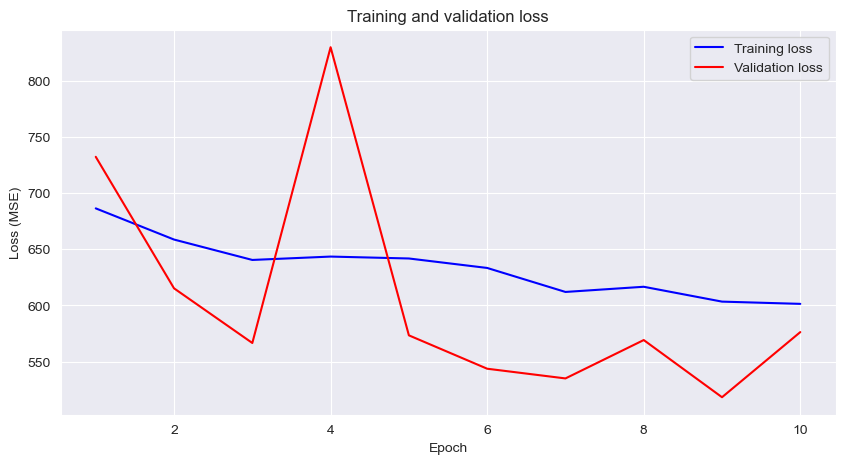

In [43]:
loss_graphs(model1)


### Model evaluation on validation data

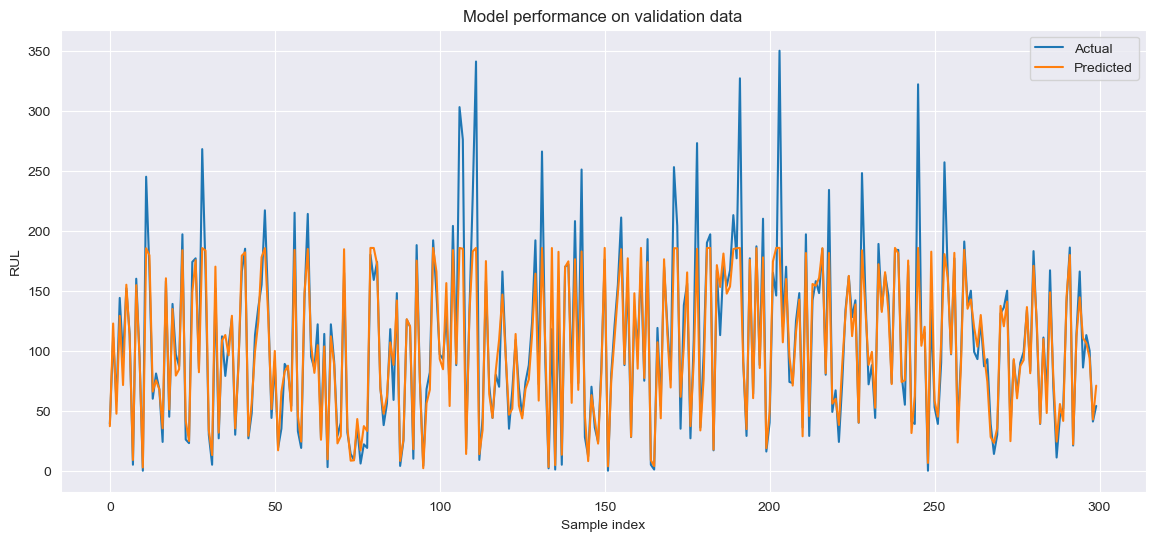

In [44]:
# Preparing data for training evaluation
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)

with torch.no_grad():
    y_train_pred = ModelTest(x_train_tensor)
    
y_train_pred = y_train_pred.cpu()
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).cpu()

# Plotting
plt.figure(figsize=(14,6))
plt.plot(y_train[0:300], label='Actual')
plt.plot(y_train_pred[0:300], label='Predicted')
plt.title('Model performance on validation data')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.legend()
plt.show()

In [45]:
# Validation data test metrics
evaluation_metrics(y_train, y_train_pred)

Mean squared error: 505.1830827191583
Root mean squared error: 22.476278222142522
R2 score: 0.8867420782406472
Mean absolute error: 13.222491829043648


# Preparing test data

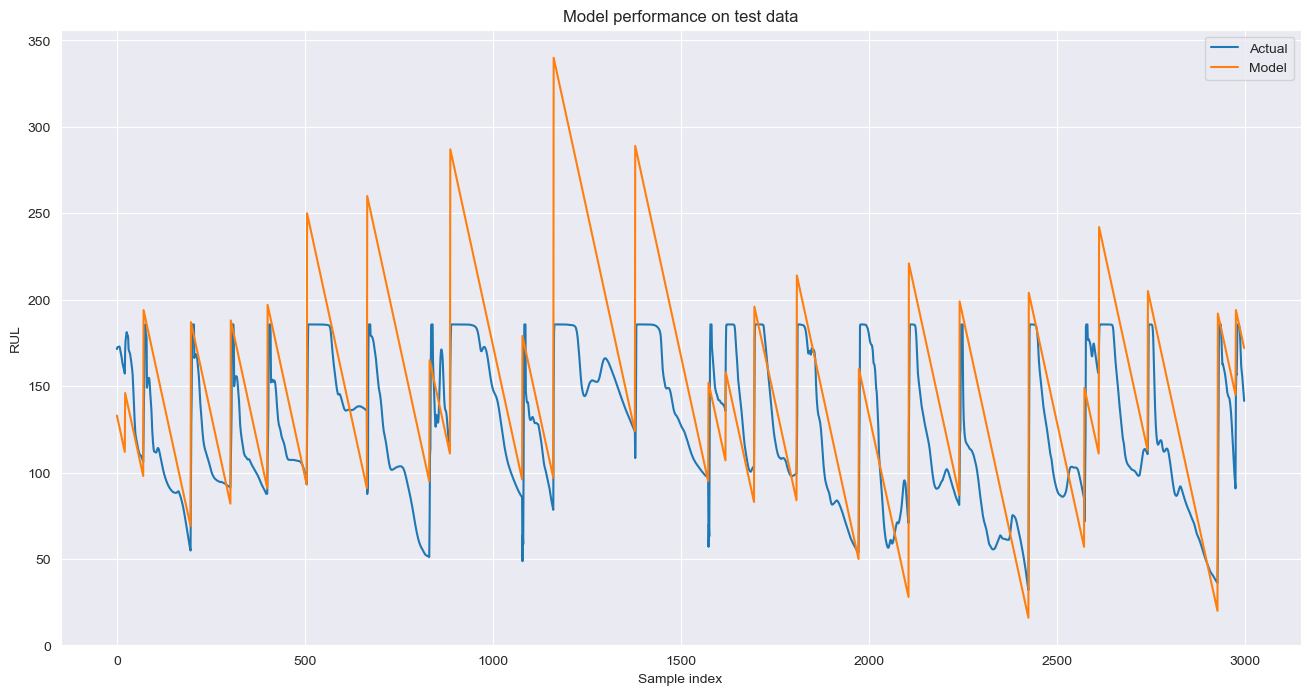

In [46]:
ModelTest.eval()
with torch.no_grad():
    y_test_pred = ModelTest(x_test_tensor)
    
y_test_pred = torch.Tensor.cpu(y_test_pred)
start_idx = 0
end_idx = 3000
truncated_ground_truth = FD001_test['RUL'][(sequence_length-1):].reset_index(drop=True)
truncated_subset = truncated_ground_truth[start_idx:end_idx].reset_index(drop=True)

plt.figure(figsize=(16,8))
plt.plot(y_test_pred[start_idx:end_idx], label='Actual')
plt.plot(truncated_subset, label='Model')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.title("Model performance on test data")
plt.legend()
plt.show()


In [47]:
# Test data evaluation
evaluation_metrics(truncated_ground_truth, y_test_pred)
print(ModelTest)
print(f"Sequence length: {sequence_length}\nBatch size: {batch_size}")

Mean squared error: 2280.504958435348
Root mean squared error: 47.75463284787506
R2 score: 0.34482717361406756
Mean absolute error: 36.13348052543033
DamagePropagationLSTM(
  (conv1): Conv1d(10, 64, kernel_size=(3,), stride=(1,), padding=same)
  (conv2): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=same)
  (globalAvgPool1D): AdaptiveAvgPool1d(output_size=32)
  (lstm1): LSTM(32, 256, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(256, 64, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (dense2): Linear(in_features=64, out_features=1, bias=True)
  (activation2): ReLU()
)
Sequence length: 10
Batch size: 128


# Automatic hyperparameter tuning
There are many hyperparameters that we can tune such as learning rate, batch size, sequence length, hidden sizes of our LSTM units, dropout percentage, etc.


In [337]:
import optuna

In [ ]:
# Objective function

def objective(trial):
    # hyperparameter search space
    lstm_hs_1 = trial.suggest_int('lstm_hs_1', 128, 256)
    lstm_hs_2 = trial.suggest_int('lstm_hs_2', 32, 64)
    cnn1_hs = trial.suggest_int('cnn1_hs', 256, 512)
    cnn2_hs = trial.suggest_int('cnn2_hs', 96, 128)
    cnn3_hs = trial.suggest_int('cnn3_hs', 16, 32)
    dropout_pc = trial.suggest_float('dropout_pc', 0.1, 0.4)
    
    # Generate model
    model_to_tune = DamagePropagationLSTM(feature_count=feature_count, out_dim=out_dim,
                                          dropout_pc=dropout_pc, lstm_hs_1=lstm_hs_1,
                                          lstm_hs_2=lstm_hs_2, cnn1_hs=cnn1_hs, cnn2_hs=cnn2_hs
                                          ).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.RMSprop(model_to_tune.parameters(), lr=trial.suggest_float('lr', 1e-4, 1e-2), weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
     
    try:
        tuning_performance = train_model(model_to_tune, criterion, optimizer, scheduler,
                                train_loader, val_loader, trial=True, num_epochs=epochs,
                                patience=10, destination=model_path, verbose=False)
    except optuna.exceptions.TrialPruned:
        raise optuna.exceptions.TrialPruned()
    
    model_to_tune.eval()
    with torch.no_grad():
        tuned_predictions = model_to_tune(x_test_tensor)
    tuned_predictions = torch.Tensor.cpu(tuned_predictions)
    acc = r2_score(truncated_ground_truth, tuned_predictions)
    return acc
        
    

In [ ]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30, n_jobs=1, gc_after_trial=True)

print('Best trial:')
trial = study.best_trial

print(' Value: ', trial.value)
print(' Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

In [ ]:
# 30 trials took about 3 hours. so it does not have to be run again we store the best values through hard-coding
temp_hs_1 = 170
temp_hs_2 = 45
temp_c_1 = 439
temp_c_2 = 104
temp_c_3 = 26
temp_dropout = 0.23916875418912822
temp_lr = 0.0026951347814880133

final_model = DamagePropagationLSTM(feature_count, out_dim, temp_dropout,
                                    temp_hs_1, temp_hs_2, temp_c_1,
                                    temp_c_2, temp_c_3).to(device)
final_optimizer = torch.optim.RMSprop(final_model.parameters(), lr=temp_lr, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(final_optimizer, mode='min', patience=5)


In [ ]:
epochs = 50

final_performance = train_model(final_model, criterion, final_optimizer, scheduler,
                                train_loader, val_loader, num_epochs=epochs,
                                patience=10, destination=model_path)


In [ ]:
loss_graphs(final_performance)

with torch.no_grad():
    
    y_tuned_pred = final_model(x_train_tensor)
    y_hat_pred = final_model(x_test_tensor)
    
y_tuned_pred = y_tuned_pred.cpu()
y_hat_pred = y_hat_pred.cpu()

plt.plot(y_train[0:150], label='Actual')
plt.plot(y_tuned_pred[0:150], label='Predicted')
plt.title('Model performance on validation data')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.legend()
plt.show()


In [ ]:
evaluation_metrics(y_train, y_tuned_pred)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_hat_pred[start_idx:end_idx], label='Actual')
plt.plot(truncated_subset, label='Model')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.title("Model performance on test data")
plt.legend()
plt.show()

In [ ]:
evaluation_metrics(truncated_ground_truth, y_hat_pred)
print(final_model)
print(f"Sequence length: {sequence_length}\nBatch size: {batch_size}")